<a href="https://colab.research.google.com/github/TOUATI-MOHAMED/Stock-Price-Prediction/blob/main/LSTM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. 
Unlike standard feedforward neural networks, LSTM has feedback connections. 
It can not only process single data points (such as images), but also entire sequences of data (such as speech or video). --Wikipedia

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective.
The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. -Stackabuse.com

Common Architecture of LSTM:
Forget Gate
Input Gate
Output Gate

'''

'\nLong short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. \nUnlike standard feedforward neural networks, LSTM has feedback connections. \nIt can not only process single data points (such as images), but also entire sequences of data (such as speech or video). --Wikipedia\n\nLSTMs are widely used for sequence prediction problems and have proven to be extremely effective.\nThe reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. -Stackabuse.com\n\nCommon Architecture of LSTM:\nForget Gate\nInput Gate\nOutput Gate\n\n'

In [ ]:
# Description: This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) 
#              to predict the closing stock price of a corporation using the past 60 day stock price.
#              
#
# Resources: https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
#            https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/
#            https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/
#            https://en.wikipedia.org/wiki/Long_short-term_memory
#            https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
#            https://medium.com/@dclengacher/keras-lstm-recurrent-neural-networks-c1f5febde03d 

In [ ]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [ ]:
#Get the Stock Quote: The price of a stock as quoted on an exchange
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17') #end = '2017-12-31', format = 'YYYY-MM-DD'
#Show the data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,51.115936
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.390648
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.961189
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.504375
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.421093
...,...,...,...,...,...,...
2019-12-11,271.100006,268.500000,268.809998,270.769989,19689200.0,270.769989
2019-12-12,272.559998,267.320007,267.779999,271.459991,34327600.0,271.459991
2019-12-13,275.299988,270.929993,271.459991,275.149994,33396900.0,275.149994


In [ ]:
#Show the number of rows and columns in the data
#The data frame has 2004 rows of data and 6 columns
df.shape

(2003, 6)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


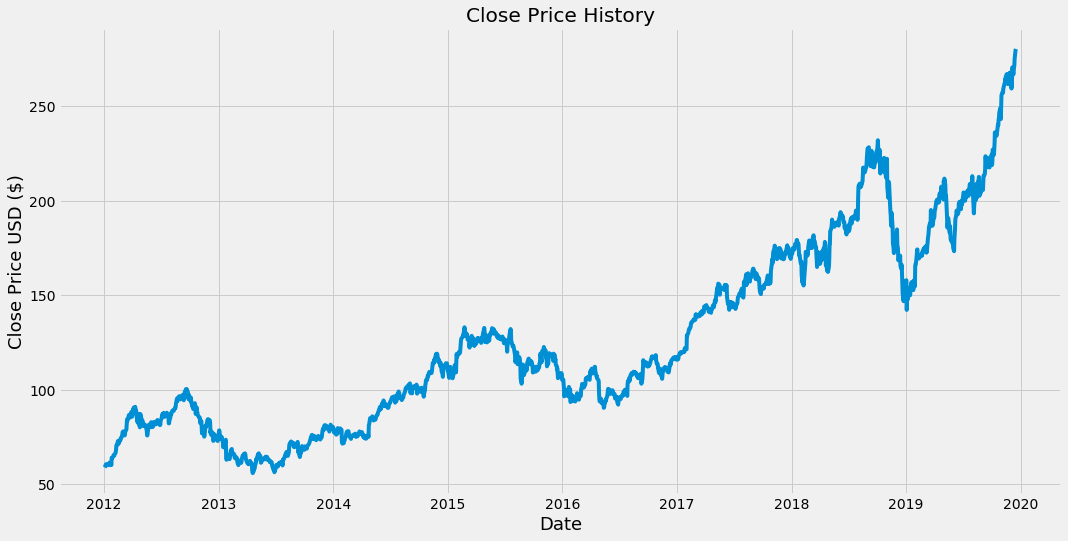

In [ ]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [ ]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
#That is equivalently the length that we want the training data set to have 
# and equivalently it is equal to the ending index - 1 of the training data set
training_data_len = math.ceil( len(dataset) *.8) # Length is about 80% of the original data, which is 2003 * .8 = 1603 rounded up


In [ ]:
#Scale the all of the data to be values between 0 and 1
#In practice it is nearly always advantageous to apply pre-processing transformations/ scaling/ normalization to the input data before it is presented to a network. 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset) #Compute the minimum and maximum to be used for later scaling to data, then transform it.

In [ ]:
#Create the training data set
#Create the scaled training data set :  a new array containing the scaled values from index 0 to 1602
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])#The independent training variables or training feature set 'X' (holds the stock price value for the past 60 days at position 'i-60')
    y_train.append(train_data[i,0])#The dependent training variables, or target, or training label set 'Y' (holds the stock price at the 61st day at position 'i-60')
#Convert x_train and y_train to numpy arrays so we can use them for training the LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

#A LSTM network expects the input to be 3-Dimensional in the form [samples, time steps, features]:
# samples is the number of data points (or rows/ records) we have, 
# time steps is the number of time-dependent steps that are there in a single data point (60),
# features/indicators refers to the number of variables we have for the corresponding true value in Y, since we are only using one feature 'Close',
# the number of features/indicators will be one
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
#Build the LSTM network model
model = Sequential()
#First LSTM layer, input_shape = the number of time steps (60 or x_train.shape[1]) while the last parameter is the number of features (1)
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1))) #Units=number of neurons, return_sequences is set to true since we will add more layers to the model.
model.add(LSTM(units=50, return_sequences=False)) #LSTM layer with 50 neurons, return sequence by default is False but I put it here just to show
model.add(Dense(units=25)) #Just your regular densely-connected Neural Network layer with 25 neurons
model.add(Dense(units=1)) #Just your regular densely-connected Neural Network layer with 1 neuron

In [ ]:
#Compile the model
# optimizer = adam and the optimizer is used to improve upon the loss
# loss function = mean_squared_error (MSE) and loss functions are used to measure how well the model did on training
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Fit / Train the model
#Batch Size: Total number of training examples present in a single batch
#Epoch:The number of iterations when an ENTIRE dataset is passed forward and backward through the neural network .
#Fit: Another word for train
model.fit(x_train, y_train, batch_size=1, epochs=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





1543/1543 [==============================] - 111s 72ms/step - loss: 0.0011


In [ ]:
#Create the testing data set
#Create the scaled testing data set : a new array containing the scaled values from index 1543 to 2002 of the dataframe, for a total length of 460, using the past 60 days
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])#The independent testing variables or testing feature set 'X' (holds the stock price value for the past 60 days at position 'i-60')
#Convert x_test to a numpy array so we can use it to test and make predictions using the LSTM model we created
x_test = np.array(x_test)

#A LSTM network expects the input to be 3-Dimensional in the form [samples, time steps, features]:
# samples is the number of data points (or rows/ records) we have, 
# time steps is the number of time-dependent steps that are there in a single data point (60),
# features/indicators refers to the number of variables we have for the corresponding true value in Y, since we are only using one feature 'Close',
# the number of features/indicators will be one
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) #Reshaping the variable to be 3-Dimensional in the form [samples, time steps, features] for the Neural Network

In [ ]:
#Getting the models predicted price values
predictions = model.predict(x_test) #Getting the models predicted price values
predictions = scaler.inverse_transform(predictions) #Undo the scaling

In [ ]:
#Get the root mean squared error (rmse)
#RMSE is a good measure of how accurately the model predicts the response
#(RMSE) is the standard deviation of the residuals (prediction errors).
#Lower values of RMSE indicate better fit. 
#Usually you want to evaluate your model with other metrics as well to truly get an idea of how well your model performs.

#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean((predictions- y_test)**2))
rmse

8.581663183333099

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


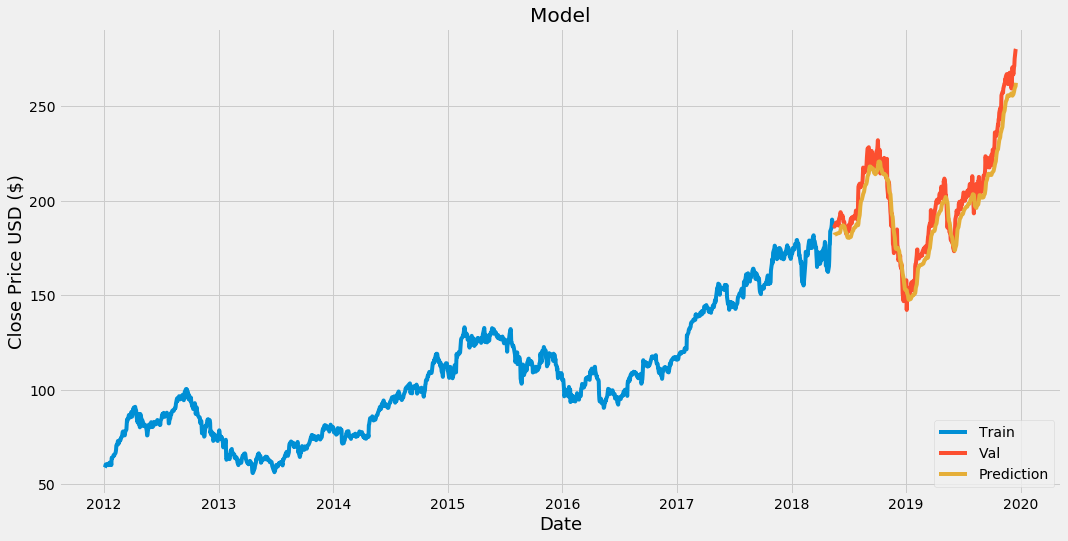

In [ ]:
#Plot the data
train = data[:training_data_len] # A dataframe to get rows from index 0 to 1602 (1603 rows total)
valid = data[training_data_len:] # A dataframe to get rows from index 1603 to the end of the list 
valid['Predictions'] = predictions #Create a new column called 'Predictions' that will hold the predicted prices

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Prediction' ], loc='lower right')
plt.show()

In [ ]:
#Show the valid/actual/close prices and predicted prices
valid

,Close,Predictions
Date,,
2018-05-17,186.990005,181.908478
2018-05-18,186.309998,182.183426
2018-05-21,187.630005,182.214249
2018-05-22,187.160004,182.271622
2018-05-23,188.360001,182.287872
...,...,...
2019-12-11,270.769989,257.660736
2019-12-12,271.459991,258.522339
2019-12-13,275.149994,259.444397


In [ ]:
#Get the quote from '2012-01-01' to '2019-12-17' to predict the closing price for '2019-12-18'
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17') 

#Create a new dataframe with only the 'Close' column
new_df = apple_quote.filter(['Close']) 
#Get the last 60 rows of data from the stock/ aka get the past 60 days of the stock and convert it to an array and store it in a variable
last_60_days = new_df[-60:].values 

#Transform the data to values between 0 and 1
last_60_days_scaled  = scaler.transform(last_60_days) 

#Create an empty list
X_test = [] 
#Append the data (the past 60 values to predict the 61st value)
X_test.append(last_60_days_scaled) 
#Convert X_test to a numpy array so we can use it to test and make predictions using the LSTM model we created
X_test = np.array(X_test) 
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

#Get the predicted scaled price
pred_price = model.predict(X_test) 
#Undo the scaling
pred_price = scaler.inverse_transform(pred_price) 
print(pred_price)#Print the predicted price



[[264.35214]]


In [ ]:
#Get the actual closing price for that day
#from datetime import datetime
today = '2019 - 12-18'
#today = datetime.today().strftime('%Y-%m-%d') #Get todays date and format it in the form YYYY-MM-DD
todays_price = web.DataReader('AAPL', data_source='yahoo', start=today, end=today) #Get the stock price for today
print(todays_price['Close']) #Print the closing price of the stock for today


Date
2019-12-18    279.73999
Name: Close, dtype: float64
